In [106]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import HomeMade as hm
import xgboost as xgb
from sklearn.metrics import roc_auc_score, roc_curve
%matplotlib notebook

Loading Data and MC -sets:

In [29]:
N = 1e7
list_of_features = "v0_la_mass v0_rxy v0_chi2 cosTheta".split(" ")

path = "data/data15_13TeV.00267358.physics_MinBias.30062015_v0_per_0.root"
file = uproot.open(path)
data = file['tree'].pandas.df(list_of_features,entrystop = N)

path = "data/mc15_13TeV.361203.Pythia8_A2_MSTW2008LO_ND_minbias.30062015_v0_per_0.root"
file = uproot.open(path)
mc = file['tree'].pandas.df(list_of_features+['trueLa'],entrystop = N)

In [39]:
mass_range = (1075,1200)
data = data.loc[(data.v0_la_mass > mass_range[0]) & (data.v0_la_mass < mass_range[1])]
mc = mc.loc[(mc.v0_la_mass > mass_range[0]) & (mc.v0_la_mass < mass_range[1])]

<IPython.core.display.Javascript object>


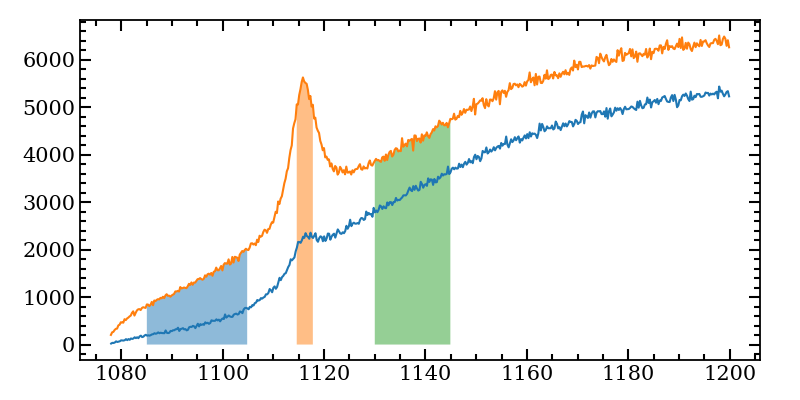

In [52]:
vals, binc, binw = hm.hist(data.v0_la_mass,bins=500)
vals_mc, binc_mc, binw_mc = hm.hist(mc.v0_la_mass,bins=500)

fig, ax = plt.subplots()
ax.plot(binc,vals)
ax.plot(binc_mc,vals_mc)

s_cut = (1114.5,1118)
b_cutl = (1085,1105)
b_cuth = (1130,1145)

ax.fill_between(binc_mc[(binc_mc>b_cutl[0])&(binc_mc<b_cutl[1])],vals_mc[(binc_mc>b_cutl[0])&(binc_mc<b_cutl[1])],zorder=-1,alpha=0.5)
ax.fill_between(binc_mc[(binc_mc>s_cut[0])&(binc_mc<s_cut[1])],vals_mc[(binc_mc>s_cut[0])&(binc_mc<s_cut[1])],zorder=-1,alpha=0.5)
ax.fill_between(binc_mc[(binc_mc>b_cuth[0])&(binc_mc<b_cuth[1])],vals_mc[(binc_mc>b_cuth[0])&(binc_mc<b_cuth[1])],zorder=-1,alpha=0.5)


In [89]:
s_sample = data.loc[(data.v0_la_mass>s_cut[0])&(data.v0_la_mass<s_cut[1])]
b_samplel = data.loc[(data.v0_la_mass>b_cutl[0])&(data.v0_la_mass<b_cutl[1])]
b_sampleh = data.loc[(data.v0_la_mass>b_cuth[0])&(data.v0_la_mass<b_cuth[1])]

min_sample = min([len(s_sample),len(b_samplel),len(b_sampleh)])
if min_sample != len(s_sample):print("WARNING! increase background samplesize or increase signal sample-size")

df = pd.concat([s_sample.sample(min_sample),
               b_samplel.sample(min_sample),
               b_sampleh.sample(min_sample)])

In [102]:
cla = xgb.XGBClassifier()
cla.fit(df[['v0_rxy', 'v0_chi2', 'cosTheta']],
       y = np.append(np.zeros(min_sample),np.ones(2*min_sample)))
cla.score(df[['v0_rxy', 'v0_chi2', 'cosTheta']],
       y = np.append(np.zeros(min_sample),np.ones(2*min_sample)))

0.7241526972687868

In [107]:
pred = cla.predict_proba(mc[['v0_rxy','v0_chi2','cosTheta']])

In [109]:
roc_auc_score(mc.trueLa,pred[:,0])

0.9291338237272748